In [1]:
import pandas as pd

import math

import numpy as np

from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import category_encoders as ce
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV

# Function

In [2]:
def histogram_subplots(dataset_analyse, variables_list, title_subplot, palette_dict, hue_variable):
    ############################################################
    row=0
    col=0
    row_max = math.ceil(len(variables_list)/2) # maximum two columns
    col_max = 2
    fig, axes = plt.subplots(row_max, col_max, figsize=(10,16)) #<==
    fig.suptitle(title_subplot+"\n") #<==
    for cols_name in variables_list:
        if col+1 == col_max:
            # Last Column
            sns.histplot(data = dataset_analyse, x = cols_name, ax =axes[row,col],
                         hue = hue_variable, palette=palette_dict, kde=True, multiple = "dodge", shrink=0.9)
            axes[row,col].tick_params(axis='x', rotation=45)
            axes[row,col].set_xlabel(None)
            axes[row,col].title.set_text(f'Variable: {cols_name}')

            row += 1
            col = 0
        else:
            # First Column
            sns.histplot(data = dataset_analyse, x = cols_name, ax =axes[row,col], 
                         hue = hue_variable, palette=palette_dict, kde=True, multiple = "dodge", shrink=0.9)
            axes[row,col].tick_params(axis='x', rotation=45)
            axes[row,col].set_xlabel(None)
            axes[row,col].title.set_text(f'Variable: {cols_name}')

            col+=1

    plt.tight_layout() # prevents overlapping

    return fig, len(variables_list)

In [3]:
def scatterplot_subplots(dataset_analyse, variables_list, title_subplot, palette_dict, hue_variable):
    ############################################################
    row=0
    col=0
    row_max = math.ceil(len(variables_list)/2) # maximum two columns
    col_max = 2
    fig, axes = plt.subplots(row_max, col_max, figsize=(10,16)) #<==
    fig.suptitle(title_subplot+"\n") 
    for pair in variables_list:
        variable1 = pair[0]
        variable2 = pair[1]
        if col+1 == col_max:
            sns.scatterplot(data = dataset_analyse,x= variable1, y= variable2, 
                            ax= axes[row,col],  hue =hue_variable, palette=palette_dict, alpha=0.4 )
            axes[row,col].tick_params(axis='x', rotation=45)
            axes[row,col].set_xlabel(variable1)  
            axes[row,col].set_ylabel(variable2) 
            axes[row,col].title.set_text(f'{variable1} vs {variable2} scatterplot')

            row += 1
            col = 0
        else:
            sns.scatterplot(data = dataset_analyse,x= variable1, y= variable2, 
                            ax= axes[row,col],  hue =hue_variable, palette=palette_dict, alpha=0.4 )
            axes[row,col].tick_params(axis='x', rotation=45)
            axes[row,col].set_xlabel(variable1)
            axes[row,col].set_ylabel(variable2) 
            axes[row,col].title.set_text(f'{variable1} vs {variable2} scatterplot')

            col+=1

    plt.tight_layout() # prevents overlapping
    
    return fig, len(variables_list)

In [4]:
def encode_ordinal_variable(full_dataset, ordinal_mapping_list):
    # encode ordinal category variable
    encoder= ce.OrdinalEncoder(return_df=True,
                               mapping=ordinal_mapping_list)
    new_full_dataset = encoder.fit_transform(full_dataset)
    
    return new_full_dataset 

In [5]:
def encode_label_variable(full_dataset, variable_list):
    # label encode
    encoding_dictionary={}
    for cols_name in variable_list:
        target_le = LabelEncoder()
        full_dataset[[cols_name]] = full_dataset[[cols_name]].apply(target_le.fit_transform)
        
        encoding_dictionary.update({target_le.classes_.tolist()[x]:x for x in range(0, len(target_le.classes_.tolist()))})
   
    return full_dataset, encoding_dictionary

# Extract Dataset

In [6]:
dataset_og = pd.read_csv("BankChurners.csv")

# Overview

In [7]:
# general info
#print(dataset_og.info())
dataset_og.head(4)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987


#### Remove Columns

In [8]:
del dataset_og["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1"]
del dataset_og["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"]

#### Summary of Missing Values

In [9]:
# Summary of missing values
total_missing = dataset_og.isnull().sum().sort_values()
percent_missing = total_missing/dataset_og.isnull().count()
missing_df = pd.DataFrame(data = {"total_missing":total_missing, "percentage_missing":percent_missing})
missing_df

,total_missing,percentage_missing
Attrition_Flag,0,0.0
Avg_Open_To_Buy,0,0.0
Avg_Utilization_Ratio,0,0.0
CLIENTNUM,0,0.0
Card_Category,0,0.0
Contacts_Count_12_mon,0,0.0
Credit_Limit,0,0.0
Customer_Age,0,0.0
Dependent_count,0,0.0
Education_Level,0,0.0


#### Summary of Variables dtypes

In [10]:
# show column names and the column dtypes
column_list = dataset_og.columns.tolist()
column_dtypes_list = dataset_og.dtypes.to_list()
df_disp = pd.DataFrame(data={"Column":column_list, "Types":column_dtypes_list})
df_disp

,Column,Types
0,CLIENTNUM,int64
1,Attrition_Flag,object
2,Customer_Age,int64
3,Gender,object
4,Dependent_count,int64
5,Education_Level,object
6,Marital_Status,object
7,Income_Category,object
8,Card_Category,object
9,Months_on_book,int64


# Extract Training and Testing Dataset
#### (Not enough data for Validation Dataset)

In [11]:
# Extract Training and Testing Dataset
target = dataset_og["Attrition_Flag"] # target
dataset = dataset_og.drop(["Attrition_Flag"], axis=1) #dependent

dataset_train, dataset_test, target_train, target_test = train_test_split(dataset, target, test_size=0.3,random_state=100)
print(len(dataset_og))
print(len(dataset_train))
print(len(dataset_test))

10127
7088
3039


# Explore Data
#### Combine dependent variable with target variable for EDA

In [12]:
# Combine the dependent variable with the target variable for EDA
dataset_eda = pd.concat([dataset_train, target_train], axis=1)

#### Summary of Unique Values information for each variable

In [13]:
# Summary of unique values:
print(f'Total Rows: {len(dataset_eda)}', end="\n"*4)
for col_name in dataset_eda.columns.tolist():
    print(f"Unique Columns in {col_name}")
    unique_list = dataset_eda[col_name].unique()
    print(f"Unique values = {unique_list}")
    print(f"Number of unique values in column = {len(unique_list)}", end="\n"*2)
    print(f"\n===Stats Column: {col_name}===", end="\n"*2)
    print(dataset_eda[col_name].value_counts(), end = "\n"*4)

Total Rows: 7088



Unique Columns in CLIENTNUM
Unique values = [712867983 714506583 780307233 ... 779916408 715009833 721332033]
Number of unique values in column = 7088


===Stats Column: CLIENTNUM===

721074183    1
708774708    1
719084358    1
764496708    1
719872833    1
            ..
749067633    1
716451183    1
714581358    1
711456108    1
708085458    1
Name: CLIENTNUM, Length: 7088, dtype: int64



Unique Columns in Customer_Age
Unique values = [54 48 44 37 39 35 50 57 56 29 49 45 60 43 58 47 46 55 40 42 52 53 51 61
 34 38 36 33 59 65 63 62 41 30 32 26 64 31 27 28 67 68 66 70]
Number of unique values in column = 44


===Stats Column: Customer_Age===

45    362
44    345
47    341
46    340
43    336
49    329
50    323
48    311
42    285
53    269
51    269
41    266
40    266
52    260
39    230
38    219
54    205
55    192
37    188
56    187
57    159
36    159
35    133
59    110
34    103
33     96
58     95
60     93
32     80
65     69
31     65
61     65
26     

#### Create a Dictionary with variables as values and variable's dtype as keys (used for analysis)

In [14]:
# create a dict with columns as keys and dtypes as values
types_dict = dataset_eda.dtypes.to_dict()

# remove the columns that serves as id
del types_dict["CLIENTNUM"]

# create a new dict with columns as dtypes and columns as values
new_types_dict = {}
for key, val in types_dict.items():
    if val.name not in new_types_dict:
        new_types_dict[val.name] = [key]
    else:
        new_types_dict[val.name].append(key)

# print the dict keys and its list of values
for key, _ in new_types_dict.items():
    print(key)
    print(new_types_dict[key], end = "\n"*2)

int64
['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct']

object
['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Attrition_Flag']

float64
['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']



## Univariate Analysis

#### Histogram Subplots of Dataset

(<Figure size 720x1152 with 6 Axes>, 6)

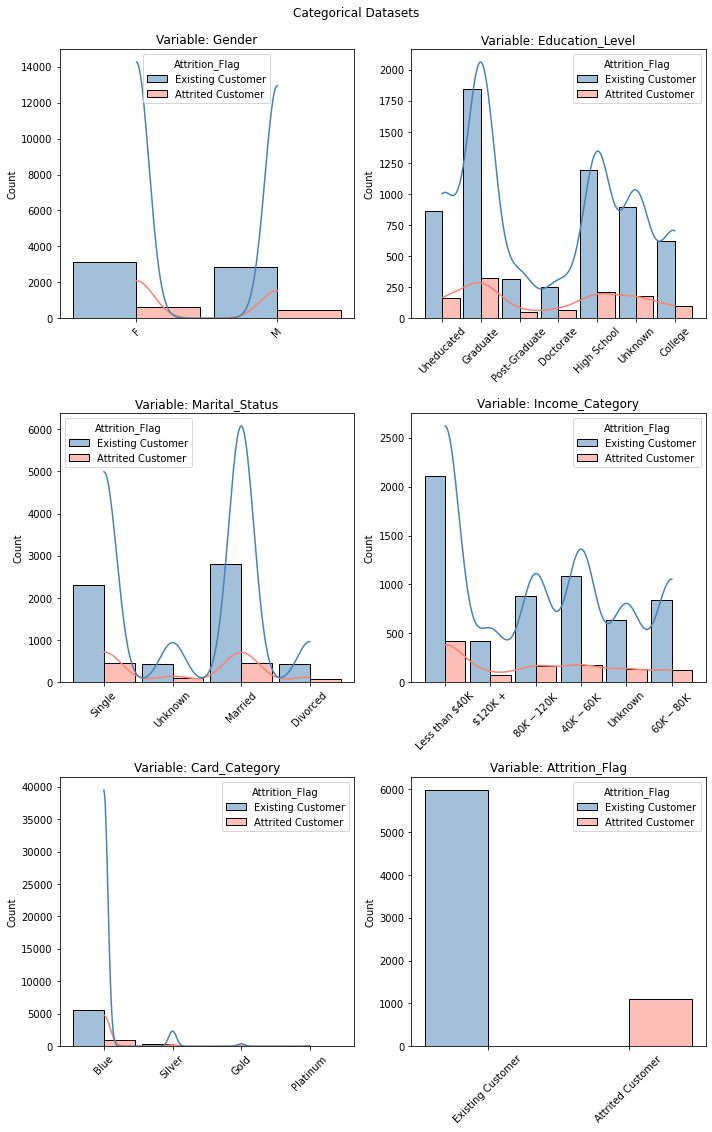

In [15]:
### Subplots of object variables
columns_list = new_types_dict["object"] #<==
title_subplot = "Categorical Datasets"
palette_dict = {"Existing Customer":"steelblue", "Attrited Customer":"salmon"}
hue_variable = "Attrition_Flag"
histogram_subplots(dataset_eda, columns_list, title_subplot, palette_dict, hue_variable)

(<Figure size 720x1152 with 10 Axes>, 9)

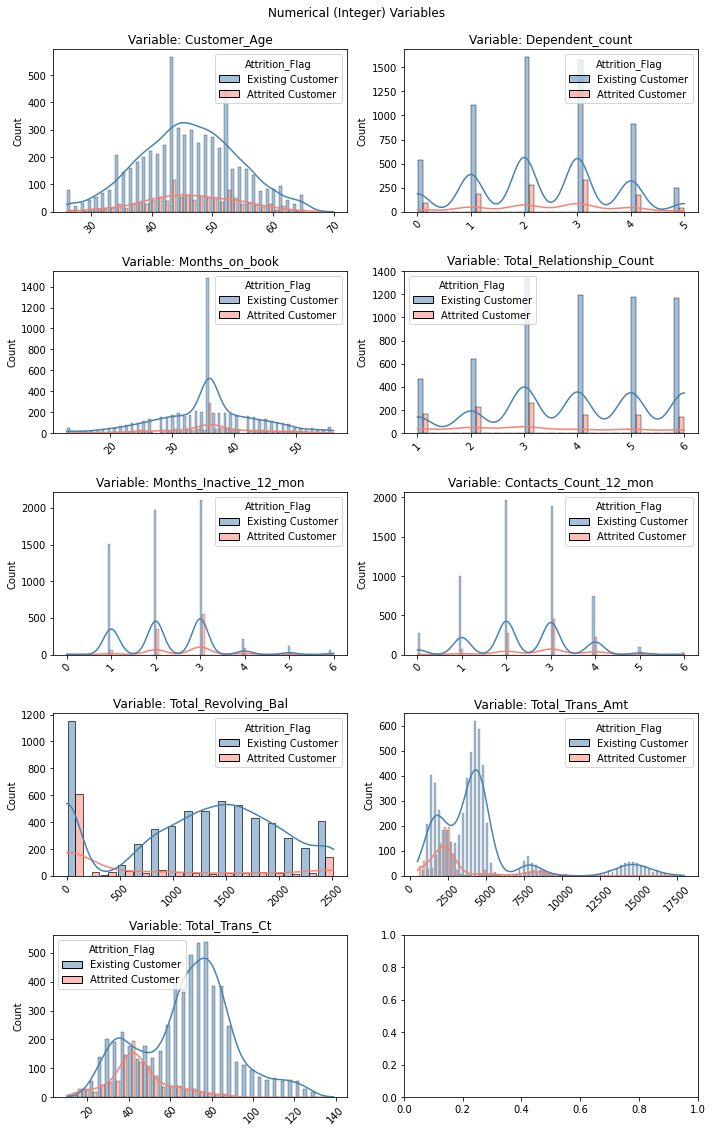

In [16]:
### Subplots of integer variables
columns_list = new_types_dict["int64"] #<==
title_subplot = "Numerical (Integer) Variables"
palette_dict = {"Existing Customer":"steelblue", "Attrited Customer":"salmon"}
hue_variable = "Attrition_Flag"
histogram_subplots(dataset_eda, columns_list, title_subplot, palette_dict, hue_variable)

(<Figure size 720x1152 with 6 Axes>, 5)

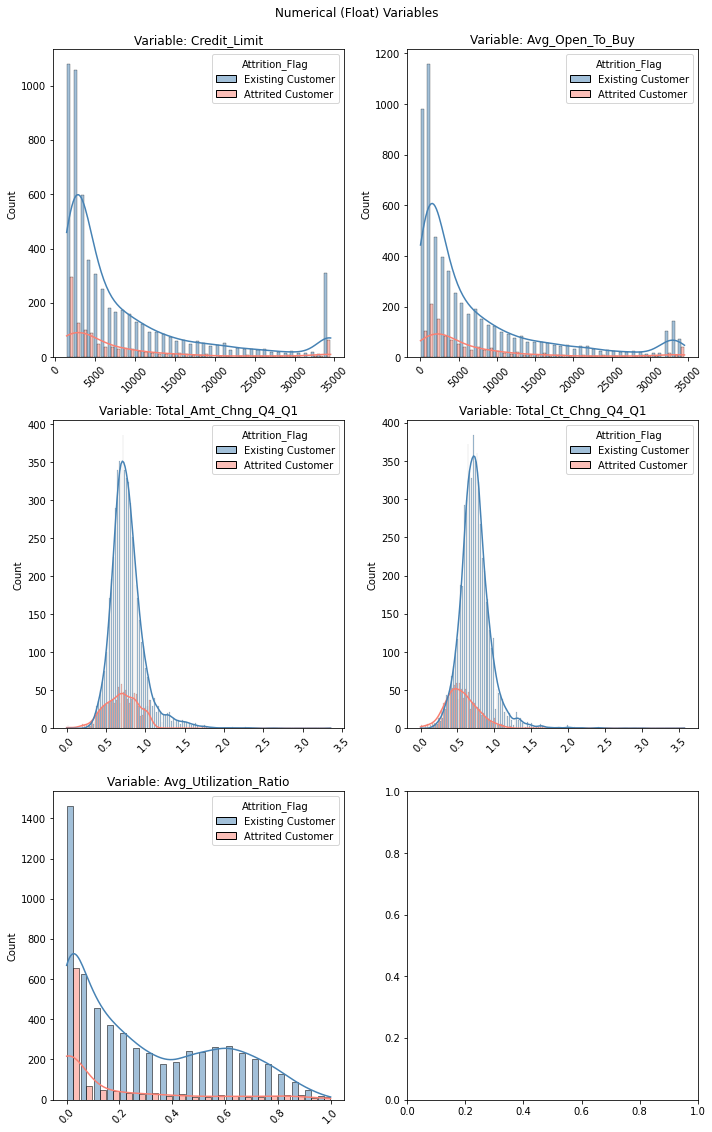

In [17]:
### Subplots of float columns
columns_list = new_types_dict["float64"] #<==
title_subplot = "Numerical (Float) Variables"
palette_dict = {"Existing Customer":"steelblue", "Attrited Customer":"salmon"}
hue_variable = "Attrition_Flag"
histogram_subplots(dataset_eda, columns_list, title_subplot, palette_dict, hue_variable)

## Bivariate Analysis

#### Correlation heatmap

In [18]:
# Remove the column which is an id
dataset_eda_bi = dataset_eda.copy()
dataset_eda_bi

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
5219,712867983,54,F,2,Uneducated,Single,Less than $40K,Blue,43,6,...,4,3006.0,633,2373.0,0.733,5177,66,0.650,0.211,Existing Customer
7568,714506583,48,F,4,Graduate,Unknown,Less than $40K,Blue,38,4,...,1,1438.3,0,1438.3,0.647,4601,78,0.625,0.000,Existing Customer
3903,780307233,44,F,2,Post-Graduate,Married,Less than $40K,Blue,30,5,...,3,1924.0,1471,453.0,1.485,3521,58,1.000,0.765,Existing Customer
8257,792098883,37,M,2,Doctorate,Single,$120K +,Blue,31,2,...,3,2360.0,1204,1156.0,0.539,3696,82,0.822,0.510,Existing Customer
9758,719379858,39,M,1,Graduate,Married,$80K - $120K,Blue,36,2,...,3,24239.0,0,24239.0,0.940,8549,73,0.780,0.000,Attrited Customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,788868858,54,M,2,Graduate,Married,Less than $40K,Blue,39,4,...,2,2702.0,2517,185.0,1.019,1658,32,1.462,0.932,Existing Customer
79,710790258,47,M,2,Graduate,Married,$80K - $120K,Blue,38,6,...,2,28904.0,1899,27005.0,0.850,1334,35,0.400,0.066,Existing Customer
8039,779916408,39,F,4,Graduate,Single,Unknown,Blue,23,1,...,2,1811.0,0,1811.0,0.835,4934,70,0.628,0.000,Existing Customer
6936,715009833,51,F,1,High School,Married,Less than $40K,Blue,36,3,...,2,1857.0,1033,824.0,0.950,5149,90,0.636,0.556,Existing Customer


<AxesSubplot:>

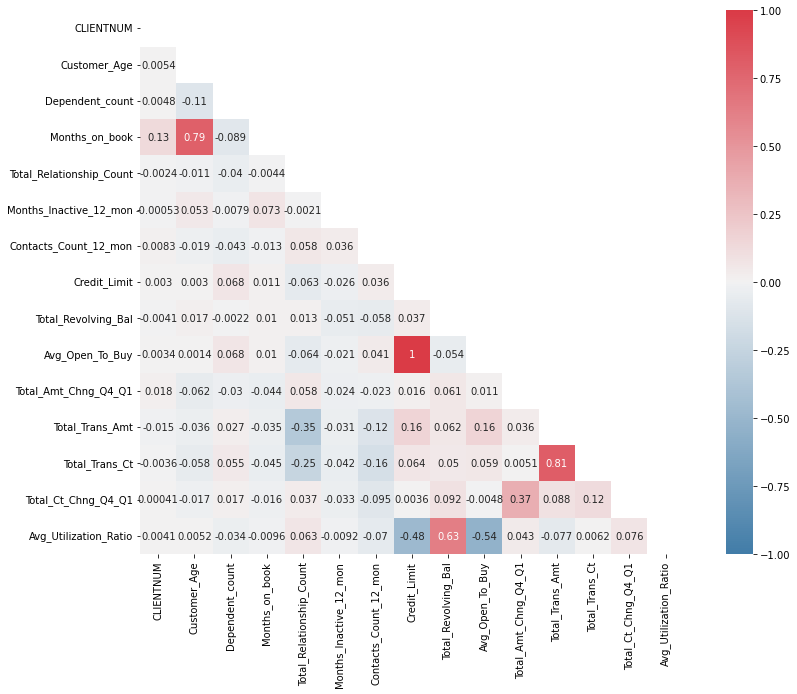

In [19]:
# print heatmap
fig, axes = plt.subplots(figsize=(15, 10))
correlation = dataset_eda_bi.corr(method = "pearson")
matrix = np.triu(correlation)
cmap_pallet = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(correlation, annot=True, square=True, mask = matrix, cmap=cmap_pallet, vmin=-1, vmax=1, center= 0)

#### Get the pair of variables that has correlation exceed threshold

In [20]:
# print the column pairs that had correlation above threshold
threshold_pos = 0.3
threshold_neg = -0.3
##########################################################

column_pairs_list = []
for col_index in range(len(correlation)):
    row_index = col_index+1 # row index +1 to exclude the column of the same name
    col_name = correlation.columns.to_list()[col_index] # column name
    if row_index == len(correlation):
        break # end of the index
    else:
        #print(str(row_index) +","+ str(col_index))
        series = correlation.iloc[row_index: len(correlation), [col_index]] # get the bottom part of the correlation table exclude same column
        
        row_name_list = series[ (series[col_name]>=threshold_pos) | (series[col_name]<=threshold_neg) ].index.to_list() # find pairs that meet threshold    
        
        temp_list = [[col_name, x] for x in row_name_list] # create the pairs that meet threshold
        column_pairs_list+=temp_list # append to list

print(column_pairs_list)

[['Customer_Age', 'Months_on_book'], ['Total_Relationship_Count', 'Total_Trans_Amt'], ['Credit_Limit', 'Avg_Open_To_Buy'], ['Credit_Limit', 'Avg_Utilization_Ratio'], ['Total_Revolving_Bal', 'Avg_Utilization_Ratio'], ['Avg_Open_To_Buy', 'Avg_Utilization_Ratio'], ['Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1'], ['Total_Trans_Amt', 'Total_Trans_Ct']]


#### Scatterplot of pairs of columns that have a positive or negative correlation

(<Figure size 720x1152 with 8 Axes>, 8)

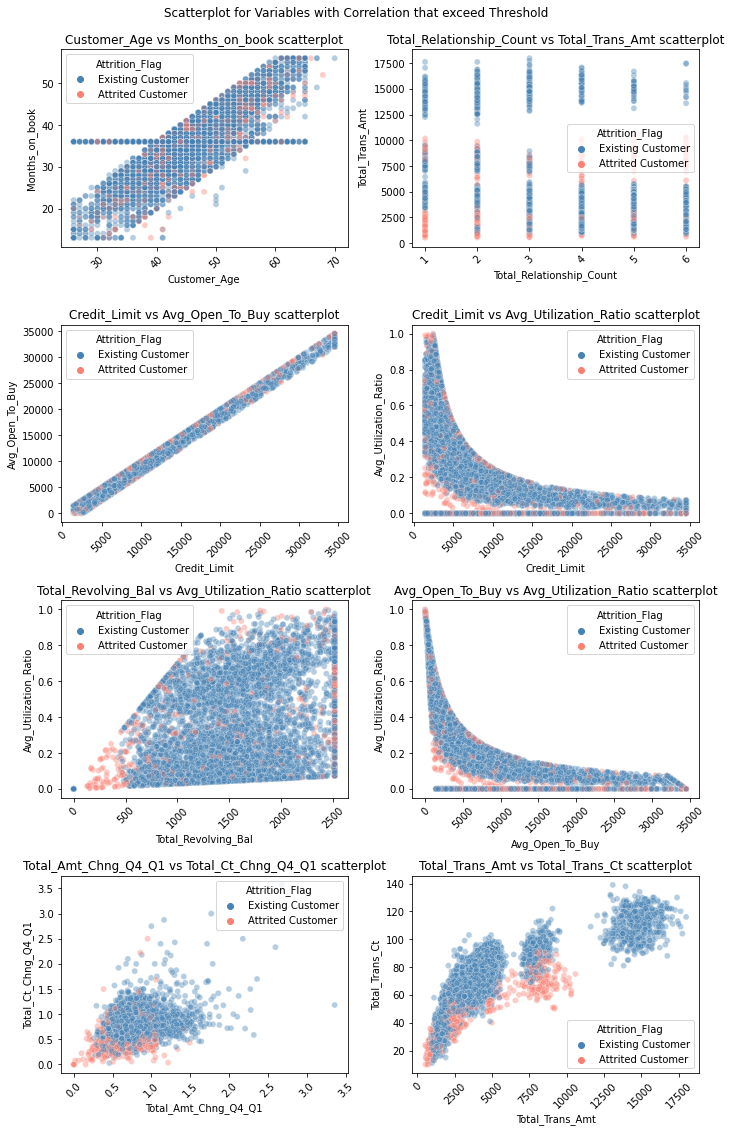

In [21]:
# Subplots of correlated Variables
columns_list = column_pairs_list
title_subplot = "Scatterplot for Variables with Correlation that exceed Threshold"
palette_dict = {"Existing Customer":"steelblue", "Attrited Customer":"salmon"}
hue_variable = "Attrition_Flag"
scatterplot_subplots(dataset_eda_bi, columns_list, title_subplot, palette_dict, hue_variable)

### Further Analysis on specific variables

#### Boxplot of Total_Relationship_Count vs Total_Trans_Amt

Text(0.5, 1.0, 'Total_Relationship_Count vs Total_Trans_Amt Boxplot')

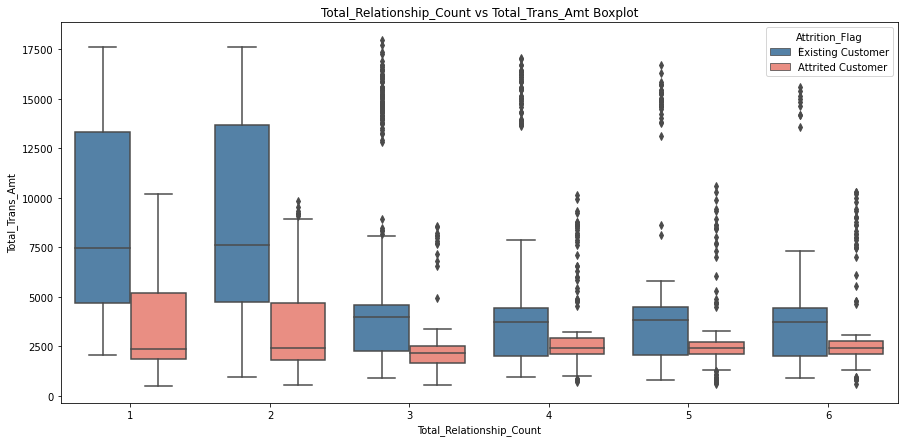

In [22]:
# Plots of Total_Relationship_Count vs Total_Trans_Amt
variable1 = "Total_Relationship_Count"
variable2 = "Total_Trans_Amt"
title_plot = f'{variable1} vs {variable2} Boxplot'
palette_dict = {"Existing Customer":"steelblue", "Attrited Customer":"salmon"}
hue_variable = "Attrition_Flag"

fig, axes = plt.subplots(figsize=(15,7))
sns.boxplot(data=dataset_eda_bi,
            x=variable1, y=variable2, 
            hue=hue_variable,
           palette = palette_dict)
axes.set_title(title_plot)

#### Scatterplot of Total_Trans_Amt vs Total_Trans_Ct brokendown into Total_Relationship_Count

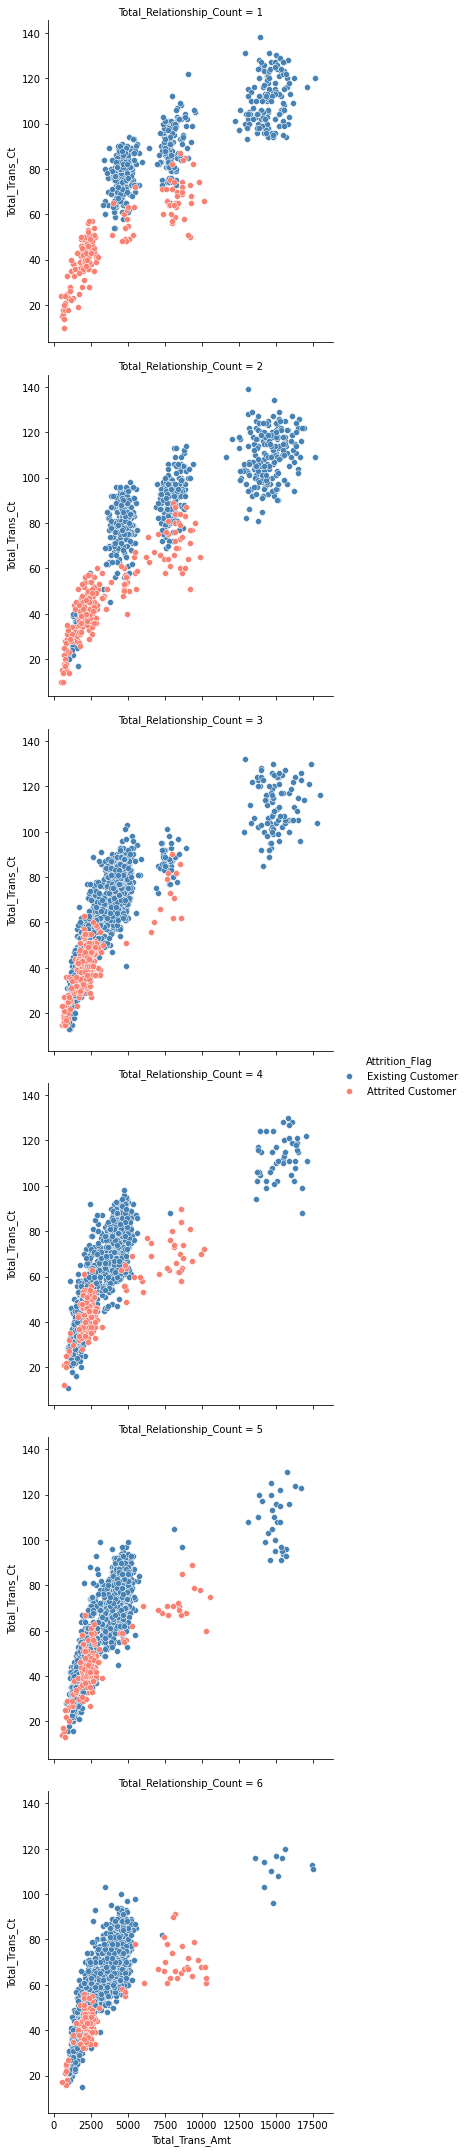

In [23]:
xaxis_variable = 'Total_Trans_Amt'
yaxis_variable = 'Total_Trans_Ct'
row_variable = 'Total_Relationship_Count'
# col_variable = 'Total_Relationship_Count'
hue_variable = "Attrition_Flag"
palette_dict = {"Existing Customer":"steelblue", "Attrited Customer":"salmon"}
######################################################

facet_grid = sns.FacetGrid(data=dataset_eda_bi, 
#                            col=col_variable,
                           row=row_variable,
                           hue=hue_variable,
                           palette= palette_dict,
                           height=5, aspect=1)
facet_grid.map(sns.scatterplot,xaxis_variable ,yaxis_variable )
facet_grid.figure.subplots_adjust(wspace=0.001, hspace=0.1)
facet_grid.add_legend()

plt.show()
# plt.tight_layout() # prevents overlapping

# Feature Selection 

### Category Variable: Feature Selection with chi2

In [24]:
category_list = new_types_dict["object"][0:len(new_types_dict["object"])-1]
categorical_dataset = dataset_train[category_list].copy()
categorical_dataset.head(2)

,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
5219,F,Uneducated,Single,Less than $40K,Blue
7568,F,Graduate,Unknown,Less than $40K,Blue


#### Encode Ordinal Variable

In [25]:
# encode ordinal category variable
# dependent Variable
ordinal_mapping_list = [{'col':'Education_Level','mapping':{'Unknown':0,'Uneducated':1, 
                                                                        'High School':2,'College':3,
                                                                        'Graduate':4,'Post-Graduate':5,
                                                                        'Doctorate':6}},
                       {'col':'Income_Category', 'mapping':{'Unknown':0,'Less than $40K':1,
                                                            '$40K - $60K':2, '$60K - $80K':3, 
                                                            '$80K - $120K':4,  '$120K +':5}},
                       {'col':'Card_Category', 'mapping':{'Blue':0,'Silver':1,
                                                            'Gold':2, 'Platinum':3}}]
new_categorical_dataset = encode_ordinal_variable(categorical_dataset, ordinal_mapping_list)
new_categorical_dataset.head(2)

,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
5219,F,1,Single,1,0
7568,F,4,Unknown,1,0


#### Encode Nominal Variable

In [26]:
# encode nominal category variable
# dependent Variable
variable_list = ["Gender","Marital_Status"]

new_categorical_dataset, encode_dic = encode_label_variable(new_categorical_dataset, variable_list)
new_categorical_dataset.head(2)

,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
5219,0,1,2,1,0
7568,0,4,3,1,0


In [27]:
encode_dic

{'F': 0, 'M': 1, 'Divorced': 0, 'Married': 1, 'Single': 2, 'Unknown': 3}

#### Encode Target Variable

In [28]:
target_train_chi2 = target_train.copy().to_frame(name="Attrition_Flag")

In [29]:
# encode Target Variable 
variable_list = ["Attrition_Flag"]

new_target_train, encode_dic = encode_label_variable(target_train_chi2, variable_list)
new_target_train.head(2)

,Attrition_Flag
5219,1
7568,1


In [30]:
encode_dic

{'Attrited Customer': 0, 'Existing Customer': 1}

#### Get the Chi2 and Mutual Information

In [31]:
# Get the Chi2 Stats
chi2_score = chi2(new_categorical_dataset, new_target_train)

chi2_dataframe = pd.DataFrame(data={"Variable Name":category_list,
                                    "Chi2Score":chi2_score[0],
                                    "p-Value":chi2_score[1]}).sort_values(by="Chi2Score",
                                                                          ascending=False)
chi2_dataframe

,Variable Name,Chi2Score,p-Value
0,Gender,5.549348,0.018488
2,Marital_Status,2.724450,0.098822
3,Income_Category,2.403128,0.121093
4,Card_Category,0.166880,0.682900
1,Education_Level,0.015824,0.899895


## Category & Numerical Variable: Feature Selection with Random Forests

In [32]:
dataset_train_rf = dataset_train.copy()

# drop the columns that is the id and target variable
dataset_train_rf.drop("CLIENTNUM", axis=1, inplace=True)

In [33]:
dataset_train_rf.shape

(7088, 19)

#### Encode Ordinal Variable

In [34]:
# encode ordinal category variable
# dependent Variable
ordinal_mapping_list = [{'col':'Education_Level','mapping':{'Unknown':0,'Uneducated':1, 
                                                                        'High School':2,'College':3,
                                                                        'Graduate':4,'Post-Graduate':5,
                                                                        'Doctorate':6}},
                       {'col':'Income_Category', 'mapping':{'Unknown':0,'Less than $40K':1,
                                                            '$40K - $60K':2, '$60K - $80K':3, 
                                                            '$80K - $120K':4,  '$120K +':5}},
                       {'col':'Card_Category', 'mapping':{'Blue':0,'Silver':1,
                                                            'Gold':2, 'Platinum':3}}]

dataset_train_rf = encode_ordinal_variable(dataset_train_rf, ordinal_mapping_list)
dataset_train_rf.head(2)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
5219,54,F,2,1,Single,1,0,43,6,1,4,3006.0,633,2373.0,0.733,5177,66,0.650,0.211
7568,48,F,4,4,Unknown,1,0,38,4,3,1,1438.3,0,1438.3,0.647,4601,78,0.625,0.000


#### One Hot Encode Nominal Variable

In [35]:
# One Hot Encode Gender
column_name = "Gender"
dataset_train_rf = pd.get_dummies(data = dataset_train_rf, columns= [column_name], prefix=column_name)
dataset_train_rf.head(2)

,Customer_Age,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M
5219,54,2,1,Single,1,0,43,6,1,4,3006.0,633,2373.0,0.733,5177,66,0.650,0.211,1,0
7568,48,4,4,Unknown,1,0,38,4,3,1,1438.3,0,1438.3,0.647,4601,78,0.625,0.000,1,0


In [36]:
# One Hot Encode Marital_Status
column_name = "Marital_Status"
dataset_train_rf = pd.get_dummies(data = dataset_train_rf, columns= [column_name], prefix=column_name)
dataset_train_rf.head(2)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
5219,54,2,1,1,0,43,6,1,4,3006.0,...,5177,66,0.650,0.211,1,0,0,0,1,0
7568,48,4,4,1,0,38,4,3,1,1438.3,...,4601,78,0.625,0.000,1,0,0,0,0,1


#### Encode Target Variable

In [37]:
target_train_rf = target_train.copy().to_frame(name="Attrition_Flag")

In [38]:
# encode Target Variable 
variable_list = ["Attrition_Flag"]

target_train_rf, encode_dic = encode_label_variable(target_train_rf, variable_list)
target_train_rf.head(2)

,Attrition_Flag
5219,1
7568,1


#### Get the feature importance with RandomForest

In [39]:
clf_featureselection = RandomForestClassifier(n_estimators=100, random_state=0)
clf_featureselection.fit(dataset_train_rf, target_train_rf)

column_name_list = dataset_train_rf.columns
importance_score_list = clf_featureselection.feature_importances_

feature_scores = pd.DataFrame(data = {"Column": column_name_list,
                                      "rf_feature_importance": importance_score_list}).sort_values(by="rf_feature_importance",
                                                                                                   ascending=False)
feature_scores

C:\Users\emily\AppData\Local\Temp\ipykernel_3916\4059389166.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_featureselection.fit(dataset_train_rf, target_train_rf)


,Column,rf_feature_importance
13,Total_Trans_Amt,0.192309
14,Total_Trans_Ct,0.153502
15,Total_Ct_Chng_Q4_Q1,0.108876
10,Total_Revolving_Bal,0.091606
6,Total_Relationship_Count,0.070041
16,Avg_Utilization_Ratio,0.063482
12,Total_Amt_Chng_Q4_Q1,0.061999
11,Avg_Open_To_Buy,0.036136
9,Credit_Limit,0.033927
0,Customer_Age,0.033770


#### Generate barchart of feature importance

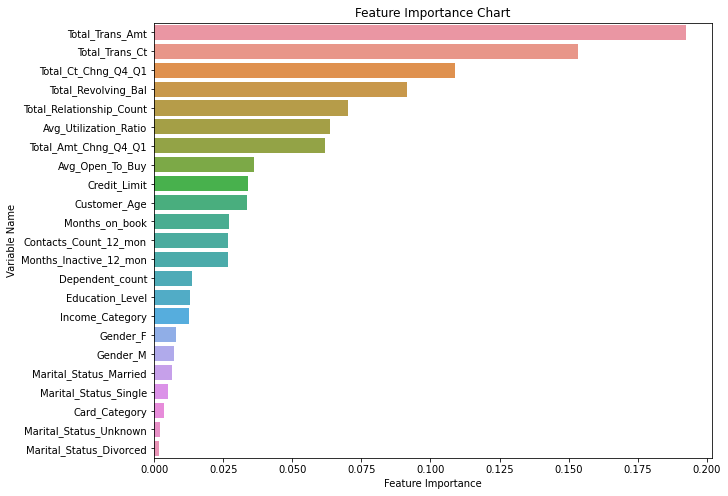

In [40]:
dataset_eda = feature_scores.copy()
x_name="rf_feature_importance"
y_name="Column"
############################

fig, axes = plt.subplots(figsize=(10,8)) #<==
sns.barplot(data = dataset_eda, x = x_name, y =y_name)
axes.set_xlabel("Feature Importance")   
axes.set_ylabel("Variable Name")  
axes.title.set_text(f'Feature Importance Chart')

# Train and Test Model Random Forest with all variables

In [41]:
dataset_training = dataset_train_rf.copy() # from feature selection with RF
target_training = target_train_rf.copy() # from feature selection with RF

dataset_testing = dataset_test.copy()
dataset_testing.drop("CLIENTNUM", axis=1, inplace=True)
target_testing = target_test.copy().to_frame(name="Attrition_Flag")

In [42]:
dataset_training.head(2)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
5219,54,2,1,1,0,43,6,1,4,3006.0,...,5177,66,0.650,0.211,1,0,0,0,1,0
7568,48,4,4,1,0,38,4,3,1,1438.3,...,4601,78,0.625,0.000,1,0,0,0,0,1


In [43]:
target_training.head(2)

,Attrition_Flag
5219,1
7568,1


#### Encode the testing dataset

In [44]:
# encode ordinal category variable
# dependent Variable
ordinal_mapping_list = [{'col':'Education_Level','mapping':{'Unknown':0,'Uneducated':1, 
                                                                        'High School':2,'College':3,
                                                                        'Graduate':4,'Post-Graduate':5,
                                                                        'Doctorate':6}},
                       {'col':'Income_Category', 'mapping':{'Unknown':0,'Less than $40K':1,
                                                            '$40K - $60K':2, '$60K - $80K':3, 
                                                            '$80K - $120K':4,  '$120K +':5}},
                       {'col':'Card_Category', 'mapping':{'Blue':0,'Silver':1,
                                                            'Gold':2, 'Platinum':3}}]

dataset_testing = encode_ordinal_variable(dataset_testing, ordinal_mapping_list)

# One Hot Encode Gender
column_name = "Gender"
dataset_testing = pd.get_dummies(data = dataset_testing, columns= [column_name], prefix=column_name)

# One Hot Encode Marital_Status
column_name = "Marital_Status"
dataset_testing = pd.get_dummies(data = dataset_testing, columns= [column_name], prefix=column_name)

# encode Target Variable 
variable_list = ["Attrition_Flag"]
target_testing, encode_dic = encode_label_variable(target_testing, variable_list)

In [45]:
dataset_testing.head(2)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
4250,48,2,0,5,0,35,3,3,4,10642.0,...,4183,74,0.762,0.161,0,1,0,1,0,0
5309,49,4,4,0,0,42,5,3,2,16424.0,...,4025,79,0.881,0.083,1,0,0,0,1,0


In [46]:
target_testing.head(2)

,Attrition_Flag
4250,1
5309,1


In [47]:
tuned_parameters = [{'n_estimators': [60,70,80,90,100]}]

# Determine best n_estimator 
clf_grid = GridSearchCV(RandomForestClassifier(random_state=20), param_grid=tuned_parameters, cv=5,scoring='accuracy')
clf_grid.fit(dataset_training.values, target_training.values)

# Training RandomForest with best n_estimator
clf_model_randomforest = RandomForestClassifier(max_depth=100, n_estimators=clf_grid.best_params_["n_estimators"],
                               criterion= "gini",random_state=20)
clf_model_randomforest.fit(dataset_training.values, target_training.values)

c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\emily\appdata\local\programs\pytho

C:\Users\emily\AppData\Local\Temp\ipykernel_3916\1060690095.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_model_randomforest.fit(dataset_training.values, target_training.values)


RandomForestClassifier(max_depth=100, n_estimators=90, random_state=20)

In [48]:
# Testing RandomForest
predict_y = clf_model_randomforest.predict(dataset_testing.values)
accuracy_score_results = accuracy_score(target_testing.values, predict_y)
precision_score_results = precision_score(target_testing.values, predict_y)
recall_score_results = recall_score(target_testing.values, predict_y)

print("Number of Estimators:",clf_grid.best_params_["n_estimators"] )
print("Accuracy:", accuracy_score_results)
print("Precision:", precision_score_results)
print("Recall:", recall_score_results)

Number of Estimators: 90
Accuracy: 0.9542612701546561
Precision: 0.9558879938626774
Recall: 0.9904610492845787


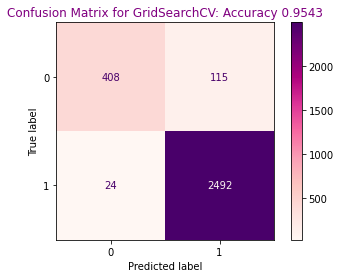

In [49]:
### Display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(target_testing.values, predict_y, cmap='RdPu')
plt.title("""Confusion Matrix for GridSearchCV: Accuracy {:.4}""".format(accuracy_score_results),color='Purple')
plt.show()

In [50]:
print(classification_report(target_testing.values, predict_y))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       523
           1       0.96      0.99      0.97      2516

    accuracy                           0.95      3039
   macro avg       0.95      0.89      0.91      3039
weighted avg       0.95      0.95      0.95      3039



# Train and Test Model Random Forest with selected variables

In [51]:
selected_variable_list = ['Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Total_Revolving_Bal', 'Total_Relationship_Count',
       'Avg_Utilization_Ratio', 'Total_Amt_Chng_Q4_Q1', 'Avg_Open_To_Buy',
       'Credit_Limit', 'Customer_Age','Months_on_book']

In [52]:
dataset_training_reduced = dataset_training[selected_variable_list]
dataset_testing_reduced = dataset_testing[selected_variable_list]
target_training_reduced = target_training.copy()
target_testing_reduced =target_testing.copy()

In [53]:
tuned_parameters = [{'n_estimators': [60,70,80,90,100]}]

# Determine best n_estimator 
clf_grid = GridSearchCV(RandomForestClassifier(random_state=20), param_grid=tuned_parameters, cv=5,scoring='accuracy')
clf_grid.fit(dataset_training_reduced.values, target_training_reduced.values)

# Training RandomForest with best n_estimator
clf_model_randomforest = RandomForestClassifier(max_depth=100, n_estimators=clf_grid.best_params_["n_estimators"],
                               criterion= "gini",random_state=20)
clf_model_randomforest.fit(dataset_training_reduced.values, target_training_reduced.values)

c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\emily\appdata\local\programs\pytho

C:\Users\emily\AppData\Local\Temp\ipykernel_3916\1984977937.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_model_randomforest.fit(dataset_training_reduced.values, target_training_reduced.values)


RandomForestClassifier(max_depth=100, random_state=20)

In [54]:
# Testing RandomForest
predict_y1 = clf_model_randomforest.predict(dataset_testing_reduced.values)
accuracy_score_results = accuracy_score(target_testing_reduced.values, predict_y1)
precision_score_results = precision_score(target_testing_reduced.values, predict_y1)
recall_score_results = recall_score(target_testing_reduced.values, predict_y1)

print("Number of Estimators:",clf_grid.best_params_["n_estimators"] )
print("Accuracy:", accuracy_score_results)
print("Precision:", precision_score_results)
print("Recall:", recall_score_results)

Number of Estimators: 100
Accuracy: 0.9601842711418229
Precision: 0.9650485436893204
Recall: 0.9876788553259142


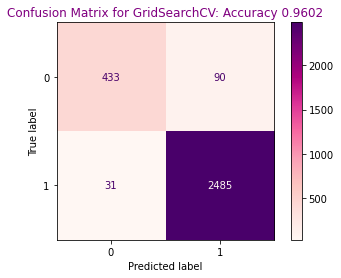

In [55]:
### Display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(target_testing_reduced.values, predict_y1, cmap='RdPu')
plt.title("""Confusion Matrix for GridSearchCV: Accuracy {:.4}""".format(accuracy_score_results),color='Purple')
plt.show()

In [56]:
print(classification_report(target_testing_reduced.values, predict_y1))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       523
           1       0.97      0.99      0.98      2516

    accuracy                           0.96      3039
   macro avg       0.95      0.91      0.93      3039
weighted avg       0.96      0.96      0.96      3039



## Observation
> __Using selected important features to train RF model improved the accuracy of the model slightly__